<a href="https://colab.research.google.com/github/skc46/Machine_learning_notebooks/blob/master/Higgs_vs_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Higgs vs background signal classification

<a href="https://colab.research.google.com/github/ML4SCIHackathon/ML4SCI/blob/main/HiggsBosonClassificationChallenge/higgs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**This is an example Notebook for running training on Higgs vs background signal classification. **

**Background:** High-energy collisions at the Large Hadron Collider (LHC) produce particles that interact with particle detectors. One important task is to classify different types of collisions based on their physics content, allowing physicists to find patterns in the data and to potentially unravel new discoveries. 

**Problem statement:** The discovery of the Higgs boson by CMS and ATLAS Collaborations was announced at CERN in 2012. In this work, we focus on the potential of Machine Learning and Deep Learning in detecting potential Higgs signal from one of the background processes that mimics it. 

**Dataset:** The dataset is made available by the Center for Machine Learning and Intelligent Systems at University of California, Irvine. 
The dataset can be found on the [UCI Machine learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS)

**Description:** The dataset consists of a total of 11 million labeled samples of Higgs vs background events produced by Monte Carlo simulations. Each sample consists of 28 features. The first 21 features are kinematic properties measured at the level of the detectors. The last seven are functions of the first 21.




**Steps to load the training dataset**
1. Download the dataset from the UCI website. 

In [ ]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2021-02-23 15:46:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  2.62MB/s    in 34m 26s 

2021-02-23 16:21:14 (1.30 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



2. Unzip the dataset folder

In [ ]:
!gzip -d HIGGS.csv.gz

In [ ]:
pip install plot-metric ## For plotting ROC at the end

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc,roc_auc_score

import matplotlib.pyplot as plt

Using TensorFlow backend.


**Load the file using pandas library**

In [ ]:
data=pd.read_csv('./HIGGS.csv')

Assign first column 0 to class labels (labeled 1 for signal, 0 for background)  and all others to feature matrix X.

In this example, for the sake of fast checking, we use 1000 samples. To train on the entire dataset, proceed with uncommenting the lines below. 

In [ ]:
data.shape

(10999999, 29)

In [ ]:
X=data.iloc[:500000,1:]
#X = data.iloc[:,1:]
y=data.iloc[:500000,0]
#y = data.iloc[:,0]

X1=data.iloc[:100000,1:]#data.iloc[:,1:]
y1=data.iloc[:10000,0]#data.iloc[:,0]

Split your data into training and validation samples where the fraction of the data used for validation is 33%. 

In [ ]:
X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape",X_train.shape)
print("X_val shape",X_val.shape)
print("X_test shape", X_test.shape)

X_train shape (320000, 28)
X_val shape (100000, 28)
X_test shape (80000, 28)


**Visualize your data - One histogram per feature column**

Detailed information on what each feature column is can be found in *Attribute Information* section on the [UCI Machine learning Repositery](https://archive.ics.uci.edu/ml/datasets/HIGGS). For further information, refer to the [paper](https://www.nature.com/articles/ncomms5308) by Baldi et. al 

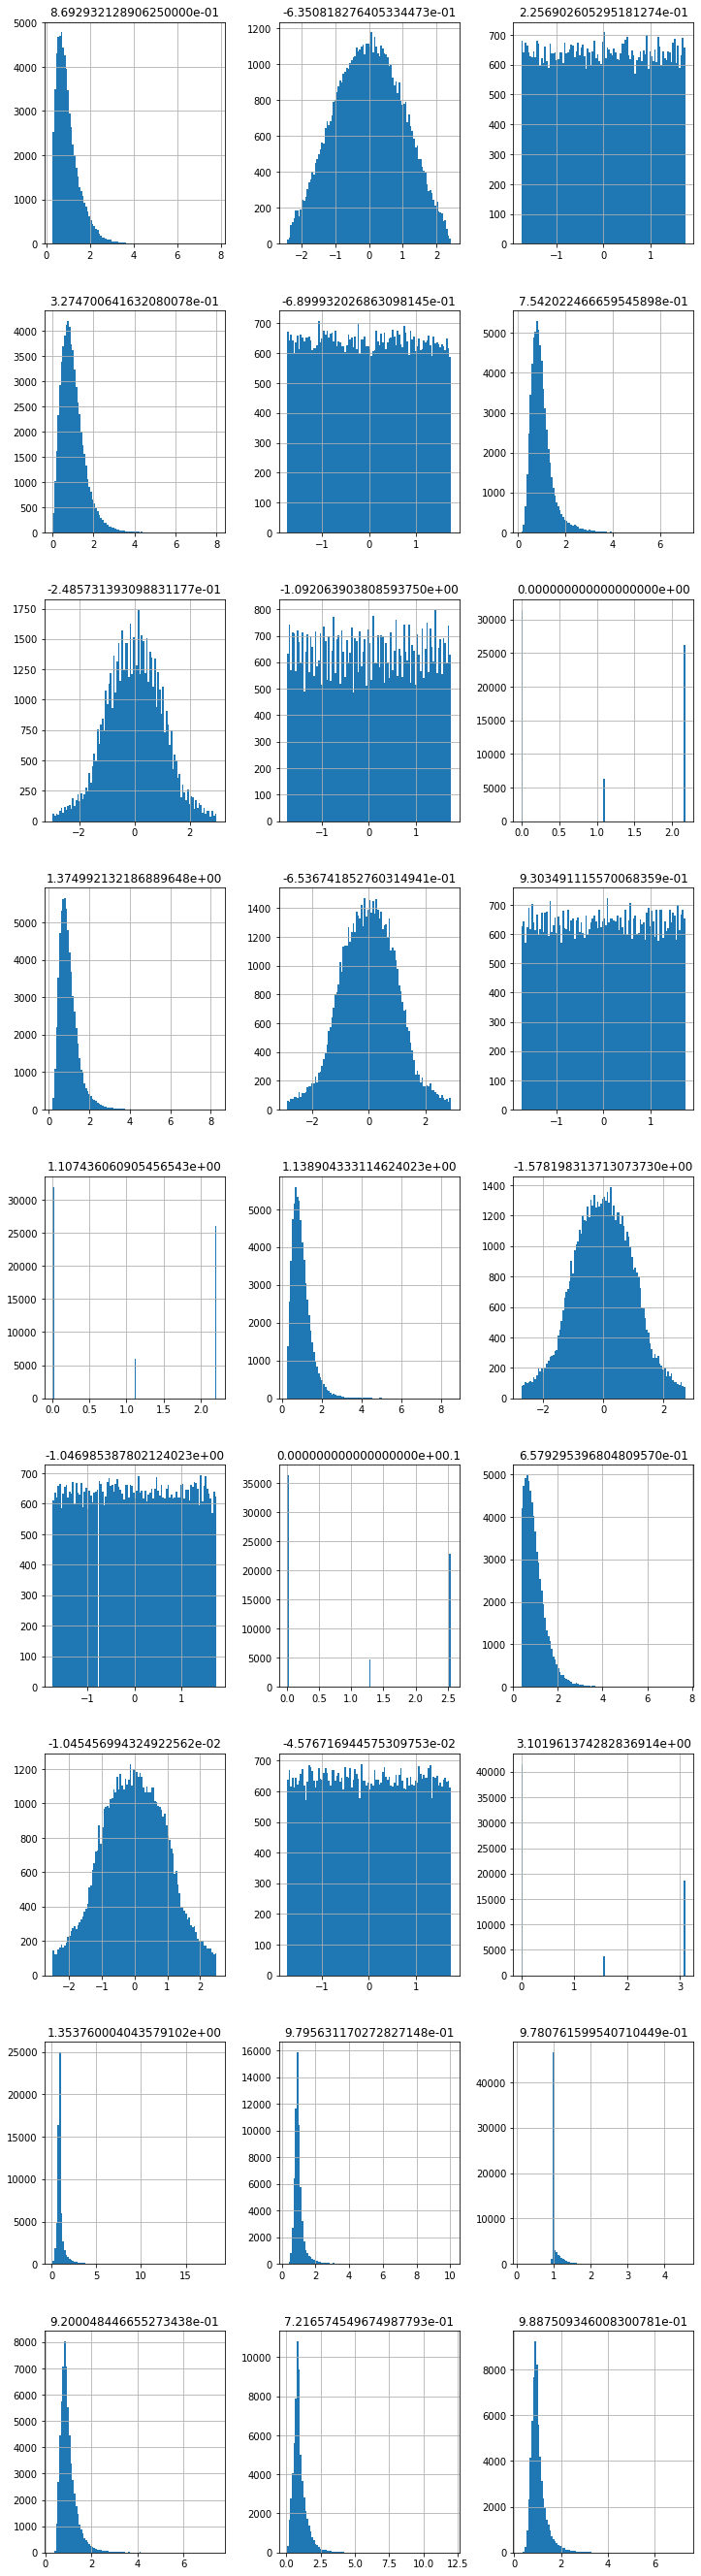

In [ ]:
from itertools import combinations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(X_train.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        X_train.hist(column = X_train.columns[i], bins = 100, ax=axis)
        i = i+1

# Boosted Decision Tree model

**Setup the Boosted Decision Tree model** (BDT explanation [here](https://docs.microsoft.com/en-us/azure/machine-learning/algorithm-module-reference/boosted-decision-tree-regression#:~:text=Boosting%20means%20that%20each%20tree,small%20risk%20of%20less%20coverage.))

In [ ]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5)

In [ ]:
estimators = [10, 50, 100, 200, 500] 
lr_rate = [0.01, 0.05, 0.1, 0.5]
grid_values = {'n_estimators': estimators, 'learning_rate':lr_rate}
clf = GridSearchCV(ada_clf,
                   grid_values, scoring='roc_auc', n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                          learning_rate=0.5, n_estimators=200),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='roc_auc')

In [ ]:
clf.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=500)

#### Finer search

In [ ]:
estimators = [300, 400, 500,600] 
lr_rate = [0.4, 0.5,0.6]
grid_values = {'n_estimators': estimators, 'learning_rate':lr_rate}
clf = GridSearchCV(ada_clf,
                   grid_values, scoring='roc_auc', n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                          learning_rate=0.5, n_estimators=200),
             n_jobs=-1,
             param_grid={'learning_rate': [0.4, 0.5, 0.6],
                         'n_estimators': [300, 400, 500, 600]},
             scoring='roc_auc')

In [ ]:
best_adaboost = clf.best_estimator_

**Train the best Boosted Decision Tree model**

In [ ]:
best_adaboost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.4, n_estimators=600)

**Predict on new testing data**

In [ ]:
predictions = best_adaboost.predict(X_test)

**Print confusion matrix**

In [ ]:
confusion_matrix(y_test, predictions)

array([[24745, 12794],
       [11390, 31071]], dtype=int64)

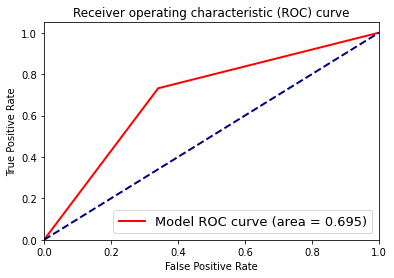

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

# Logistic Regression Classifier:

**Hyperparameter tuning**

In [ ]:

grid_lr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

logreg = LogisticRegression(solver="liblinear")

logreg_cv = GridSearchCV(logreg,grid_lr,cv=4,verbose=3)

logreg_cv.fit(X_train,y_train)

Fitting 4 folds for each of 14 candidates, totalling 56 fits
[CV] C=0.001, penalty=l1 .............................................
[CV] ................. C=0.001, penalty=l1, score=0.612, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................. C=0.001, penalty=l1, score=0.602, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................
[CV] ................. C=0.001, penalty=l1, score=0.613, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ................. C=0.001, penalty=l1, score=0.605, total=   0.2s
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.636, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.630, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.634, total=   0.4s
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.625, total=   0.3s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................. C=0.01, penalty=l1, score=0.646, total=   0.5s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................. C=0.01, penalty=l1, score=0.640, total=   0.5s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:   31.0s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

**Best Parameters**

In [ ]:
print("Best parameters of Logistic Regression from grid search:")
print(logreg_cv.best_params_)

Best parameters of Logistic Regression from grid search:
{'C': 1.0, 'penalty': 'l2'}


In [ ]:
logreg_best_est = logreg_cv.best_estimator_
logreg_best_est

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Fitting the logistic model with best parameters**

In [ ]:
best_logistic = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

best_logistic.fit(X_train, y_train)

C:\Users\shambhu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(n_jobs=-1, solver='liblinear')

In [ ]:
predictions = best_logistic.predict(X_test)

**Confusion Matrix**

In [ ]:
print("Confusion Matrix for Logistic Regression Classifier:")
confusion_matrix(y_test,predictions)

Confusion Matrix for Logistic Regression Classifier:


array([[19754, 17785],
       [11020, 31441]], dtype=int64)

**ROC Curve and Score**

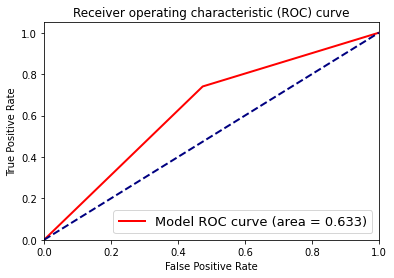

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

In [ ]:
z = confusion_matrix(y_test,predictions)

err_lr = (z[1][0]+z[0][1])/(z[0][0]+z[0][1]+z[1][0]+z[1][1])
acc_lr = 1-err_lr
print("Error of logistic regression classifier on test set:",err_lr)
print("Accuracy of logistic regression classifier on test set:",acc_lr)

Error of logistic regression classifier on test set: 0.3600625
Accuracy of logistic regression classifier on test set: 0.6399375


# Random Forest Classifier

**Hyperparameter Tuning**

In [ ]:
estimator = RandomForestClassifier()

estimators = [10, 50, 100, 200, 500] 
max_depths = [3, 6, 10, 15, 20] 
grid_values = {'n_estimators': estimators, 'max_depth':max_depths}
clf = GridSearchCV(RandomForestClassifier(),
                   grid_values, scoring='roc_auc', n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
best_n_estimators_value = clf.best_params_['n_estimators']
best_max_depth_value = clf.best_params_['max_depth']
best_score = clf.best_score_

**Best Parameters from Grid Search**

In [ ]:
print("Best parameters of RF from grid search:")
print(clf.best_params_)

clf_best_est = clf.best_estimator_
print("Best estimator:",clf_best_est)

Best parameters of RF from grid search:
{'max_depth': 20, 'n_estimators': 500}
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


**Fitting RandomClassifer using optimized hyperparameters**

In [ ]:
best_RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

best_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=500)

In [ ]:
RF_predictions = best_RF.predict(X_test)

**Confusion Matrix**

In [ ]:
print("Confusion Matrix for Random Forest Classifier:")
confusion_matrix(y_test,RF_predictions)

Confusion Matrix for Random Forest Classifier:


array([[26397, 11142],
       [10327, 32134]], dtype=int64)

**ROC Curve and Score**

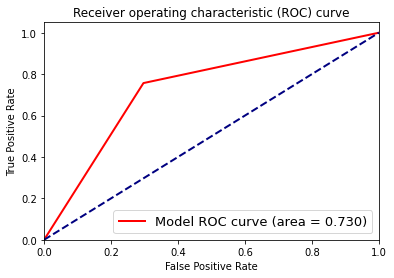

In [ ]:
fpr, tpr, _ = roc_curve(y_test, RF_predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

In [ ]:
z2 = confusion_matrix(y_test,RF_predictions)

err_rf = (z2[1][0]+z2[0][1])/(z2[0][0]+z2[0][1]+z2[1][0]+z2[1][1])
acc_rf = 1-err_rf
print("Error of logistic regression classifier on test set:",err_rf)
print("Accuracy of logistic regression classifier on test set:",acc_rf)

Error of logistic regression classifier on test set: 0.2683625
Accuracy of logistic regression classifier on test set: 0.7316374999999999


# XGB Classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy.random as rnd
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

In [ ]:
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        random_state=42, 
                        n_jobs=-1,
                        eval_metric=["error", "auc"], 
                        booster='dart', 
                        sample_type= 'weighted',
                        normalize_type= 'forest',
                        sampling_method='uniform',
                        use_label_encoder=False) #tree_method = "gpu_hist" may create data loss 
      
param_search = {
    "n_estimators" : rnd.randint(0,1000,50),
    "max_depth" : rnd.randint(0,20,10),
    "learning_rate" : rnd.uniform(0,0.5,10),
    #'gamma' : rnd.uniform(0,10),
    "colsample_bytree" : rnd.uniform(0,1.,10),
    "colsample_bylevel" : rnd.uniform(0,1.,10),
    "colsample_bynode" : rnd.uniform(0,1.,10),
    #"subsample" : rnd.uniform(0.2,1.,10),
    #"rate_drop" : rnd.uniform(0,1.,10),
    #"skip_drop" : rnd.uniform(0,1.,10)
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
num_folds = 3
num_iter = 50
kfold = StratifiedKFold(n_splits=num_folds, random_state=42, shuffle=True)
grid_search = RandomizedSearchCV(
    estimator=xgb_clf, 
    param_distributions=param_search,
    cv=kfold,
    scoring=scoring,
    #n_jobs=-1,
    n_iter=num_iter,
    refit="AUC",
)
#eval_set=[(X_val,y_val)]
best_model = grid_search.fit(X_train,y_train)

[22:22:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:58:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are 

[05:27:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:30:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:34:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are 

[21:51:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:00:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are 

[02:17:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:20:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:23:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are 

[03:56:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:58:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:01:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are 

[07:31:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:44:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are 

In [ ]:
best_model.cv_results_

{'mean_fit_time': array([21.96547341, 29.02774668, 21.66680956, 19.10544761,  8.35294954,
        15.06165878, 11.9305462 , 10.6008153 ,  6.80825766, 24.45511063,
        14.7127924 , 19.95655076, 19.1066196 , 15.45023799, 14.39364425,
        11.52226241,  8.20725505, 20.03678433, 13.28293196, 17.21548843,
         6.78183834, 20.54576135,  4.61920762, 14.84713372, 14.95835797,
         4.22244501, 13.16060368,  8.7299974 , 31.93294605, 15.02562094,
        43.17972406, 15.86571161,  8.96909372, 20.71717127, 11.80238191,
        13.62118268, 13.12503306, 11.67423828,  7.34080736, 15.34339372,
         9.5292689 ,  9.85098306, 22.51250839, 18.30226771, 19.30284452,
        17.76940068,  9.56372809,  9.56379493, 13.45256813,  4.5047853 ]),
 'std_fit_time': array([2.78617896, 1.24302716, 3.55428265, 0.66645753, 0.19706758,
        0.34526324, 0.18700283, 0.34562013, 0.24702052, 2.89224242,
        0.82642367, 0.07253171, 1.71003061, 0.44823849, 0.88800276,
        0.12669086, 0.85830648,

In [ ]:
best_model.best_estimator_

XGBClassifier(base_score=0.5, booster='dart',
              colsample_bylevel=0.31696699391249494,
              colsample_bynode=0.7079695141668899,
              colsample_bytree=0.7605077928405758, eval_metric=['error', 'auc'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2573911776624463,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=21, n_estimators=100,
              n_jobs=-1, normalize_type='forest', num_parallel_tree=1,
              objective='binary:logistic', random_state=42,
              rate_drop=0.17486098180406717, reg_alpha=0, reg_lambda=1,
              sample_type='weighted', sampling_method='uniform',
              scale_pos_weight=1, skip_drop=0.6481067054432781, ...)

In [ ]:
best_model.best_score_

0.7920321702033245

## Best Parameters:

In [ ]:
best_parameters = best_model.best_params_
best_parameters

{'subsample': 0.799477060124367,
 'skip_drop': 0.6481067054432781,
 'rate_drop': 0.17486098180406717,
 'n_estimator': 21,
 'max_depth': 7,
 'learning_rate': 0.2573911776624463,
 'colsample_bytree': 0.7605077928405758,
 'colsample_bynode': 0.7079695141668899,
 'colsample_bylevel': 0.31696699391249494}

In [ ]:
X_vals = X_val.values

In [ ]:
y_pred_xgb = best_model.predict(X_vals)
confusion_matrix(y_val,y_pred_xgb)
accuracy_score(y_val,y_pred_xgb)
classification_report(y_val,y_pred_xgb, output_dict=True)

{'0.0': {'precision': 0.5281320985497117,
  'recall': 0.6399534194367986,
  'f1-score': 0.5786904078116026,
  'support': 9446},
 '1.0': {'precision': 0.6024082300678045,
  'recall': 0.4882509001326511,
  'f1-score': 0.5393552438769103,
  'support': 10554},
 'accuracy': 0.5599,
 'macro avg': {'precision': 0.5652701643087581,
  'recall': 0.5641021597847249,
  'f1-score': 0.5590228258442564,
  'support': 20000},
 'weighted avg': {'precision': 0.5673276131518092,
  'recall': 0.5599,
  'f1-score': 0.5579332418032654,
  'support': 20000}}

In [ ]:
best_model.predict_proba(X_vals) # predicting probability of belonging to each class

array([[0.50481296, 0.49518704],
       [0.39899653, 0.60100347],
       [0.5464762 , 0.4535238 ],
       ...,
       [0.48292196, 0.51707804],
       [0.36468953, 0.6353105 ],
       [0.5157404 , 0.48425958]], dtype=float32)

[15:25:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.62753	validation_0-error:0.39750


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.70009	validation_0-error:0.34950
[2]	validation_0-auc:0.70852	validation_0-error:0.35287
[3]	validation_0-auc:0.71410	validation_0-error:0.34537
[4]	validation_0-auc:0.72601	validation_0-error:0.33500
[5]	validation_0-auc:0.72756	validation_0-error:0.33387
[6]	validation_0-auc:0.72802	validation_0-error:0.33463
[7]	validation_0-auc:0.73513	validation_0-error:0.32837
[8]	validation_0-auc:0.74032	validation_0-error:0.32706
[9]	validation_0-auc:0.74711	validation_0-error:0.31881
[10]	validation_0-auc:0.74630	validation_0-error:0.31681
[11]	validation_0-auc:0.74673	validation_0-error:0.31631
[12]	validation_0-auc:0.75645	validation_0-error:0.31206
[13]	validation_0-auc:0.75778	validation_0-error:0.31225
[14]	validation_0-auc:0.76034	validation_0-error:0.30900
[15]	validation_0-auc:0.75917	validation_0-error:0.31188
[16]	validation_0-auc:0.75957	validation_0-error:0.31244
[17]	validation_0-auc:0.75852	validation_0-error:0.31475
[18]	validation_0-auc:0.76383	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.69234	validation_0-error:0.36025
[2]	validation_0-auc:0.69096	validation_0-error:0.36006
[3]	validation_0-auc:0.69592	validation_0-error:0.35625
[4]	validation_0-auc:0.70151	validation_0-error:0.35425
[5]	validation_0-auc:0.69874	validation_0-error:0.35644
[6]	validation_0-auc:0.69864	validation_0-error:0.35775
[7]	validation_0-auc:0.73304	validation_0-error:0.33163
[8]	validation_0-auc:0.74012	validation_0-error:0.32975
[9]	validation_0-auc:0.73439	validation_0-error:0.33294
[10]	validation_0-auc:0.74099	validation_0-error:0.32494
[11]	validation_0-auc:0.75174	validation_0-error:0.31594
[12]	validation_0-auc:0.75314	validation_0-error:0.31694
[13]	validation_0-auc:0.75757	validation_0-error:0.31169
[14]	validation_0-auc:0.75739	validation_0-error:0.31394
[15]	validation_0-auc:0.75543	validation_0-error:0.31519
[16]	validation_0-auc:0.75777	validation_0-error:0.31300
[17]	validation_0-auc:0.76199	validation_0-error:0.31175
[18]	validation_0-auc:0.76129	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.69247	validation_0-error:0.35938
[2]	validation_0-auc:0.68679	validation_0-error:0.36562
[3]	validation_0-auc:0.69630	validation_0-error:0.35537
[4]	validation_0-auc:0.70036	validation_0-error:0.34975
[5]	validation_0-auc:0.70082	validation_0-error:0.35144
[6]	validation_0-auc:0.70169	validation_0-error:0.34956
[7]	validation_0-auc:0.73489	validation_0-error:0.33044
[8]	validation_0-auc:0.74038	validation_0-error:0.32475
[9]	validation_0-auc:0.73445	validation_0-error:0.32881
[10]	validation_0-auc:0.74030	validation_0-error:0.32806
[11]	validation_0-auc:0.75248	validation_0-error:0.31519
[12]	validation_0-auc:0.75511	validation_0-error:0.31406
[13]	validation_0-auc:0.75669	validation_0-error:0.31338
[14]	validation_0-auc:0.75753	validation_0-error:0.31212
[15]	validation_0-auc:0.75709	validation_0-error:0.31619
[16]	validation_0-auc:0.75865	validation_0-error:0.31169
[17]	validation_0-auc:0.76153	validation_0-error:0.31238
[18]	validation_0-auc:0.76156	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.65336	validation_0-error:0.38312
[2]	validation_0-auc:0.65903	validation_0-error:0.37906
[3]	validation_0-auc:0.65462	validation_0-error:0.38494
[4]	validation_0-auc:0.67348	validation_0-error:0.37156
[5]	validation_0-auc:0.67796	validation_0-error:0.37000
[6]	validation_0-auc:0.68303	validation_0-error:0.36725
[7]	validation_0-auc:0.69252	validation_0-error:0.36138
[8]	validation_0-auc:0.70892	validation_0-error:0.35031
[9]	validation_0-auc:0.72200	validation_0-error:0.34275
[10]	validation_0-auc:0.72247	validation_0-error:0.34431
[11]	validation_0-auc:0.71771	validation_0-error:0.34619
[12]	validation_0-auc:0.71680	validation_0-error:0.34531
[13]	validation_0-auc:0.71467	validation_0-error:0.34700
[14]	validation_0-auc:0.71568	validation_0-error:0.34644
[15]	validation_0-auc:0.72344	validation_0-error:0.34200
[16]	validation_0-auc:0.72503	validation_0-error:0.33800
[17]	validation_0-auc:0.72906	validation_0-error:0.33637
[18]	validation_0-auc:0.72540	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.55899	validation_0-error:0.44525
[1]	validation_0-auc:0.60088	validation_0-error:0.42000
[2]	validation_0-auc:0.60067	validation_0-error:0.42244
[3]	validation_0-auc:0.60754	validation_0-error:0.41887
[4]	validation_0-auc:0.60855	validation_0-error:0.41956
[5]	validation_0-auc:0.60301	validation_0-error:0.42288
[6]	validation_0-auc:0.60690	validation_0-error:0.41919
[7]	validation_0-auc:0.69381	validation_0-error:0.35925
[8]	validation_0-auc:0.67905	validation_0-error:0.36925
[9]	validation_0-auc:0.66844	validation_0-error:0.38156
[10]	validation_0-auc:0.69002	validation_0-error:0.36000
[11]	validation_0-auc:

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.55562	validation_0-error:0.44844
[1]	validation_0-auc:0.60823	validation_0-error:0.41750
[2]	validation_0-auc:0.60525	validation_0-error:0.42044
[3]	validation_0-auc:0.60920	validation_0-error:0.41763
[4]	validation_0-auc:0.60144	validation_0-error:0.41937
[5]	validation_0-auc:0.59925	validation_0-error:0.42494
[6]	validation_0-auc:0.60271	validation_0-error:0.42638
[7]	validation_0-auc:0.68958	validation_0-error:0.36912
[8]	validation_0-auc:0.67700	validation_0-error:0.37506
[9]	validation_0-auc:0.66704	validation_0-error:0.38300
[10]	validation_0-auc:0.68289	validation_0-error:0.36738
[11]	validation_0-auc:

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.68982	validation_0-error:0.35900
[2]	validation_0-auc:0.71069	validation_0-error:0.35219
[3]	validation_0-auc:0.72501	validation_0-error:0.34013
[4]	validation_0-auc:0.72798	validation_0-error:0.33569
[5]	validation_0-auc:0.73399	validation_0-error:0.33175
[6]	validation_0-auc:0.73503	validation_0-error:0.33313
[7]	validation_0-auc:0.73776	validation_0-error:0.33119
[8]	validation_0-auc:0.73828	validation_0-error:0.33131
[9]	validation_0-auc:0.74103	validation_0-error:0.33081
[10]	validation_0-auc:0.73919	validation_0-error:0.33669
[11]	validation_0-auc:0.74304	validation_0-error:0.32969
[12]	validation_0-auc:0.74685	validation_0-error:0.32700
[13]	validation_0-auc:0.75131	validation_0-error:0.32312
[14]	validation_0-auc:0.75379	validation_0-error:0.32000
[15]	validation_0-auc:0.75203	validation_0-error:0.32400
[16]	validation_0-auc:0.75073	validation_0-error:0.32456
[17]	validation_0-auc:0.75265	validation_0-error:0.31981
[18]	validation_0-auc:0.75513	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-auc:0.72067	validation_0-error:0.34856
[4]	validation_0-auc:0.72171	validation_0-error:0.34525
[5]	validation_0-auc:0.72568	validation_0-error:0.34619
[6]	validation_0-auc:0.73348	validation_0-error:0.33956
[7]	validation_0-auc:0.73927	validation_0-error:0.33237
[8]	validation_0-auc:0.74124	validation_0-error:0.32775
[9]	validation_0-auc:0.74477	validation_0-error:0.32675
[10]	validation_0-auc:0.74995	validation_0-error:0.32206
[11]	validation_0-auc:0.75427	validation_0-error:0.31875
[12]	validation_0-auc:0.75498	validation_0-error:0.31738
[13]	validation_0-auc:0.75450	validation_0-error:0.31844
[14]	validation_0-auc:0.75513	validation_0-error:0.31825
[15]	validation_0-auc:0.75651	validation_0-error:0.31756
[16]	validation_0-auc:0.75768	validation_0-error:0.31644
[17]	validation_0-auc:0.76045	validation_0-error:0.31500
[18]	validation_0-auc:0.76174	validation_0-error:0.31375
[19]	validation_0-auc:0.76208	validation_0-error:0.31331
[20]	validation_0-auc:0.76269	validati

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-auc:0.72258	validation_0-error:0.34337
[4]	validation_0-auc:0.72643	validation_0-error:0.34181
[5]	validation_0-auc:0.72782	validation_0-error:0.34219
[6]	validation_0-auc:0.73262	validation_0-error:0.33394
[7]	validation_0-auc:0.73486	validation_0-error:0.33337
[8]	validation_0-auc:0.73770	validation_0-error:0.32856
[9]	validation_0-auc:0.74226	validation_0-error:0.32594
[10]	validation_0-auc:0.74672	validation_0-error:0.32131
[11]	validation_0-auc:0.75102	validation_0-error:0.31906
[12]	validation_0-auc:0.75113	validation_0-error:0.31750
[13]	validation_0-auc:0.75290	validation_0-error:0.31819
[14]	validation_0-auc:0.75430	validation_0-error:0.31656
[15]	validation_0-auc:0.75660	validation_0-error:0.31238
[16]	validation_0-auc:0.75652	validation_0-error:0.31538
[17]	validation_0-auc:0.75975	validation_0-error:0.31412
[18]	validation_0-auc:0.76219	validation_0-error:0.31081
[19]	validation_0-auc:0.76230	validation_0-error:0.31106
[20]	validation_0-auc:0.76321	validati

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.66101	validation_0-error:0.38019
[3]	validation_0-auc:0.68020	validation_0-error:0.36575
[4]	validation_0-auc:0.67284	validation_0-error:0.37150
[5]	validation_0-auc:0.65892	validation_0-error:0.38081
[6]	validation_0-auc:0.67775	validation_0-error:0.37094
[7]	validation_0-auc:0.69337	validation_0-error:0.35931
[8]	validation_0-auc:0.70773	validation_0-error:0.34887
[9]	validation_0-auc:0.69889	validation_0-error:0.35763
[10]	validation_0-auc:0.70365	validation_0-error:0.35863
[11]	validation_0-auc:0.70644	validation_0-error:0.34987
[12]	validation_0-auc:0.72531	validation_0-error:0.33687
[13]	validation_0-auc:0.72892	validation_0-error:0.33469
[14]	validation_0-auc:0.73234	validation_0-error:0.33175
[15]	validation_0-auc:0.73230	validation_0-error:0.33113
[16]	validation_0-auc:0.73497	validation_0-error:0.33144
[17]	validation_0-auc:0.73690	validation_0-error:0.33394
[18]	validation_0-auc:0.73594	validation_0-error:0.33225
[19]	validation_0-auc:0.73108	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.65823	validation_0-error:0.38838
[3]	validation_0-auc:0.66026	validation_0-error:0.38719
[4]	validation_0-auc:0.65936	validation_0-error:0.38738
[5]	validation_0-auc:0.65840	validation_0-error:0.38931
[6]	validation_0-auc:0.64837	validation_0-error:0.40306
[7]	validation_0-auc:0.67771	validation_0-error:0.37019
[8]	validation_0-auc:0.68118	validation_0-error:0.37212
[9]	validation_0-auc:0.69634	validation_0-error:0.35550
[10]	validation_0-auc:0.69974	validation_0-error:0.35863
[11]	validation_0-auc:0.72699	validation_0-error:0.33781
[12]	validation_0-auc:0.73233	validation_0-error:0.33513
[13]	validation_0-auc:0.73387	validation_0-error:0.33644
[14]	validation_0-auc:0.73023	validation_0-error:0.34169
[15]	validation_0-auc:0.72752	validation_0-error:0.34187
[16]	validation_0-auc:0.72677	validation_0-error:0.33675
[17]	validation_0-auc:0.72244	validation_0-error:0.34131
[18]	validation_0-auc:0.71466	validation_0-error:0.34606
[19]	validation_0-auc:0.71632	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.66284	validation_0-error:0.38456
[3]	validation_0-auc:0.66378	validation_0-error:0.38175
[4]	validation_0-auc:0.66409	validation_0-error:0.38112
[5]	validation_0-auc:0.66475	validation_0-error:0.38288
[6]	validation_0-auc:0.64900	validation_0-error:0.39575
[7]	validation_0-auc:0.67856	validation_0-error:0.37362
[8]	validation_0-auc:0.68066	validation_0-error:0.36738
[9]	validation_0-auc:0.68772	validation_0-error:0.36088
[10]	validation_0-auc:0.69431	validation_0-error:0.36275
[11]	validation_0-auc:0.72214	validation_0-error:0.34363
[12]	validation_0-auc:0.72816	validation_0-error:0.34025
[13]	validation_0-auc:0.72909	validation_0-error:0.34225
[14]	validation_0-auc:0.72755	validation_0-error:0.34394
[15]	validation_0-auc:0.72501	validation_0-error:0.34731
[16]	validation_0-auc:0.72385	validation_0-error:0.33756
[17]	validation_0-auc:0.72166	validation_0-error:0.34194
[18]	validation_0-auc:0.71278	validation_0-error:0.34937
[19]	validation_0-auc:0.71632	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.69523	validation_0-error:0.35619
[2]	validation_0-auc:0.70431	validation_0-error:0.34813
[3]	validation_0-auc:0.71716	validation_0-error:0.33831
[4]	validation_0-auc:0.72165	validation_0-error:0.33500
[5]	validation_0-auc:0.74239	validation_0-error:0.31850
[6]	validation_0-auc:0.74042	validation_0-error:0.32400
[7]	validation_0-auc:0.74367	validation_0-error:0.31894
[8]	validation_0-auc:0.74523	validation_0-error:0.31869
[9]	validation_0-auc:0.74333	validation_0-error:0.31788
[10]	validation_0-auc:0.74360	validation_0-error:0.31956
[11]	validation_0-auc:0.74505	validation_0-error:0.32075
[12]	validation_0-auc:0.74866	validation_0-error:0.31844
[13]	validation_0-auc:0.74975	validation_0-error:0.31538
[14]	validation_0-auc:0.75045	validation_0-error:0.31656
[15]	validation_0-auc:0.75190	validation_0-error:0.31606
[16]	validation_0-auc:0.75366	validation_0-error:0.31450
[17]	validation_0-auc:0.75409	validation_0-error:0.31300
[18]	validation_0-auc:0.75457	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.68108	validation_0-error:0.37356
[3]	validation_0-auc:0.69340	validation_0-error:0.36094
[4]	validation_0-auc:0.70127	validation_0-error:0.35687
[5]	validation_0-auc:0.71946	validation_0-error:0.34219
[6]	validation_0-auc:0.72754	validation_0-error:0.33487
[7]	validation_0-auc:0.73420	validation_0-error:0.33025
[8]	validation_0-auc:0.73751	validation_0-error:0.32800
[9]	validation_0-auc:0.73953	validation_0-error:0.32856
[10]	validation_0-auc:0.73961	validation_0-error:0.32963
[11]	validation_0-auc:0.74291	validation_0-error:0.32569
[12]	validation_0-auc:0.74607	validation_0-error:0.32275
[13]	validation_0-auc:0.74778	validation_0-error:0.32006
[14]	validation_0-auc:0.74759	validation_0-error:0.32062
[15]	validation_0-auc:0.74910	validation_0-error:0.31938
[16]	validation_0-auc:0.74763	validation_0-error:0.32038
[17]	validation_0-auc:0.74818	validation_0-error:0.32025
[18]	validation_0-auc:0.74885	validation_0-error:0.32138
[19]	validation_0-auc:0.74907	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.68700	validation_0-error:0.36281
[3]	validation_0-auc:0.69790	validation_0-error:0.35325
[4]	validation_0-auc:0.70755	validation_0-error:0.35263
[5]	validation_0-auc:0.72649	validation_0-error:0.33681
[6]	validation_0-auc:0.73443	validation_0-error:0.33100
[7]	validation_0-auc:0.74117	validation_0-error:0.32594
[8]	validation_0-auc:0.74279	validation_0-error:0.32681
[9]	validation_0-auc:0.74306	validation_0-error:0.32931
[10]	validation_0-auc:0.74196	validation_0-error:0.32863
[11]	validation_0-auc:0.74391	validation_0-error:0.32744
[12]	validation_0-auc:0.74704	validation_0-error:0.32462
[13]	validation_0-auc:0.74718	validation_0-error:0.32206
[14]	validation_0-auc:0.74656	validation_0-error:0.32181
[15]	validation_0-auc:0.74694	validation_0-error:0.32319
[16]	validation_0-auc:0.74688	validation_0-error:0.32244
[17]	validation_0-auc:0.74609	validation_0-error:0.32219
[18]	validation_0-auc:0.74703	validation_0-error:0.32112
[19]	validation_0-auc:0.74678	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.68334	validation_0-error:0.36725
[2]	validation_0-auc:0.69239	validation_0-error:0.35750
[3]	validation_0-auc:0.70600	validation_0-error:0.35050
[4]	validation_0-auc:0.71704	validation_0-error:0.34175
[5]	validation_0-auc:0.73201	validation_0-error:0.33019
[6]	validation_0-auc:0.72993	validation_0-error:0.33056
[7]	validation_0-auc:0.73320	validation_0-error:0.32775
[8]	validation_0-auc:0.73611	validation_0-error:0.32931
[9]	validation_0-auc:0.73551	validation_0-error:0.32762
[10]	validation_0-auc:0.73335	validation_0-error:0.33087
[11]	validation_0-auc:0.73270	validation_0-error:0.32850
[12]	validation_0-auc:0.73338	validation_0-error:0.33087
[13]	validation_0-auc:0.73580	validation_0-error:0.32681
[14]	validation_0-auc:0.74222	validation_0-error:0.32494
[15]	validation_0-auc:0.74678	validation_0-error:0.32012
[16]	validation_0-auc:0.74515	validation_0-error:0.32031
[17]	validation_0-auc:0.75230	validation_0-error:0.31744
[18]	validation_0-auc:0.75137	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.66685	validation_0-error:0.37750
[2]	validation_0-auc:0.65967	validation_0-error:0.38425
[3]	validation_0-auc:0.69593	validation_0-error:0.35575
[4]	validation_0-auc:0.70126	validation_0-error:0.35237
[5]	validation_0-auc:0.71028	validation_0-error:0.34725
[6]	validation_0-auc:0.71695	validation_0-error:0.34331
[7]	validation_0-auc:0.72403	validation_0-error:0.33650
[8]	validation_0-auc:0.72342	validation_0-error:0.33919
[9]	validation_0-auc:0.72455	validation_0-error:0.33963
[10]	validation_0-auc:0.72320	validation_0-error:0.33969
[11]	validation_0-auc:0.72696	validation_0-error:0.33413
[12]	validation_0-auc:0.72831	validation_0-error:0.33313
[13]	validation_0-auc:0.73119	validation_0-error:0.33250
[14]	validation_0-auc:0.74049	validation_0-error:0.32644
[15]	validation_0-auc:0.74007	validation_0-error:0.32556
[16]	validation_0-auc:0.74011	validation_0-error:0.32512
[17]	validation_0-auc:0.74277	validation_0-error:0.32406
[18]	validation_0-auc:0.74340	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.66093	validation_0-error:0.38131
[2]	validation_0-auc:0.65485	validation_0-error:0.38394
[3]	validation_0-auc:0.69732	validation_0-error:0.35675
[4]	validation_0-auc:0.70228	validation_0-error:0.35406
[5]	validation_0-auc:0.71107	validation_0-error:0.34887
[6]	validation_0-auc:0.71773	validation_0-error:0.33881
[7]	validation_0-auc:0.72222	validation_0-error:0.33900
[8]	validation_0-auc:0.72648	validation_0-error:0.33475
[9]	validation_0-auc:0.72556	validation_0-error:0.33363
[10]	validation_0-auc:0.72365	validation_0-error:0.33744
[11]	validation_0-auc:0.72690	validation_0-error:0.33563
[12]	validation_0-auc:0.72763	validation_0-error:0.33406
[13]	validation_0-auc:0.72930	validation_0-error:0.33437
[14]	validation_0-auc:0.73750	validation_0-error:0.32444
[15]	validation_0-auc:0.73819	validation_0-error:0.32175
[16]	validation_0-auc:0.73656	validation_0-error:0.32156
[17]	validation_0-auc:0.73875	validation_0-error:0.32288
[18]	validation_0-auc:0.74008	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.69179	validation_0-error:0.35962
[2]	validation_0-auc:0.69958	validation_0-error:0.35263
[3]	validation_0-auc:0.70861	validation_0-error:0.34819
[4]	validation_0-auc:0.71422	validation_0-error:0.34556
[5]	validation_0-auc:0.72963	validation_0-error:0.33313
[6]	validation_0-auc:0.72827	validation_0-error:0.33625
[7]	validation_0-auc:0.73166	validation_0-error:0.33300
[8]	validation_0-auc:0.73006	validation_0-error:0.33256
[9]	validation_0-auc:0.73282	validation_0-error:0.32762
[10]	validation_0-auc:0.73400	validation_0-error:0.32856
[11]	validation_0-auc:0.73520	validation_0-error:0.32656
[12]	validation_0-auc:0.73353	validation_0-error:0.32819
[13]	validation_0-auc:0.73732	validation_0-error:0.32781
[14]	validation_0-auc:0.73921	validation_0-error:0.32762
[15]	validation_0-auc:0.73960	validation_0-error:0.32831
[16]	validation_0-auc:0.74306	validation_0-error:0.32338
[17]	validation_0-auc:0.74966	validation_0-error:0.31681
[18]	validation_0-auc:0.75219	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.68804	validation_0-error:0.36112
[3]	validation_0-auc:0.69607	validation_0-error:0.35813
[4]	validation_0-auc:0.70261	validation_0-error:0.34969
[5]	validation_0-auc:0.71875	validation_0-error:0.34169
[6]	validation_0-auc:0.72717	validation_0-error:0.33319
[7]	validation_0-auc:0.73217	validation_0-error:0.33331
[8]	validation_0-auc:0.73532	validation_0-error:0.33056
[9]	validation_0-auc:0.73718	validation_0-error:0.32906
[10]	validation_0-auc:0.73824	validation_0-error:0.33037
[11]	validation_0-auc:0.73935	validation_0-error:0.32931
[12]	validation_0-auc:0.73846	validation_0-error:0.32975
[13]	validation_0-auc:0.74037	validation_0-error:0.32925
[14]	validation_0-auc:0.74167	validation_0-error:0.32788
[15]	validation_0-auc:0.74280	validation_0-error:0.32469
[16]	validation_0-auc:0.74300	validation_0-error:0.32425
[17]	validation_0-auc:0.74312	validation_0-error:0.32400
[18]	validation_0-auc:0.74424	validation_0-error:0.32456
[19]	validation_0-auc:0.74467	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.68687	validation_0-error:0.36219
[3]	validation_0-auc:0.69316	validation_0-error:0.35513
[4]	validation_0-auc:0.70086	validation_0-error:0.35031
[5]	validation_0-auc:0.71644	validation_0-error:0.34331
[6]	validation_0-auc:0.72518	validation_0-error:0.33744
[7]	validation_0-auc:0.73054	validation_0-error:0.33369
[8]	validation_0-auc:0.73369	validation_0-error:0.33269
[9]	validation_0-auc:0.73516	validation_0-error:0.33281
[10]	validation_0-auc:0.73602	validation_0-error:0.33087
[11]	validation_0-auc:0.73725	validation_0-error:0.32950
[12]	validation_0-auc:0.73715	validation_0-error:0.32844
[13]	validation_0-auc:0.73784	validation_0-error:0.33013
[14]	validation_0-auc:0.73876	validation_0-error:0.32875
[15]	validation_0-auc:0.74079	validation_0-error:0.32650
[16]	validation_0-auc:0.74074	validation_0-error:0.32638
[17]	validation_0-auc:0.74117	validation_0-error:0.32469
[18]	validation_0-auc:0.74311	validation_0-error:0.32462
[19]	validation_0-auc:0.74300	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-auc:0.63493	validation_0-error:0.40100
[4]	validation_0-auc:0.65474	validation_0-error:0.38569
[5]	validation_0-auc:0.67669	validation_0-error:0.37144
[6]	validation_0-auc:0.68820	validation_0-error:0.36806
[7]	validation_0-auc:0.69144	validation_0-error:0.36144
[8]	validation_0-auc:0.68503	validation_0-error:0.37094
[9]	validation_0-auc:0.68631	validation_0-error:0.37131
[10]	validation_0-auc:0.68307	validation_0-error:0.37050
[11]	validation_0-auc:0.67951	validation_0-error:0.36794
[12]	validation_0-auc:0.68871	validation_0-error:0.36488
[13]	validation_0-auc:0.70041	validation_0-error:0.35425
[14]	validation_0-auc:0.69630	validation_0-error:0.35763
[15]	validation_0-auc:0.70325	validation_0-error:0.34975
[16]	validation_0-auc:0.70002	validation_0-error:0.35594
[17]	validation_0-auc:0.70083	validation_0-error:0.35487
[18]	validation_0-auc:0.69866	validation_0-error:0.35419
[19]	validation_0-auc:0.69196	validation_0-error:0.36125
[20]	validation_0-auc:0.68816	validati

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-auc:0.61108	validation_0-error:0.41900
[4]	validation_0-auc:0.63735	validation_0-error:0.39781
[5]	validation_0-auc:0.64707	validation_0-error:0.39038
[6]	validation_0-auc:0.64405	validation_0-error:0.39331
[7]	validation_0-auc:0.68384	validation_0-error:0.36712
[8]	validation_0-auc:0.68505	validation_0-error:0.36556
[9]	validation_0-auc:0.68528	validation_0-error:0.36875
[10]	validation_0-auc:0.70203	validation_0-error:0.35213
[11]	validation_0-auc:0.70750	validation_0-error:0.34863
[12]	validation_0-auc:0.70450	validation_0-error:0.35037
[13]	validation_0-auc:0.72645	validation_0-error:0.33519
[14]	validation_0-auc:0.71398	validation_0-error:0.34406
[15]	validation_0-auc:0.71033	validation_0-error:0.34637
[16]	validation_0-auc:0.71437	validation_0-error:0.34275
[17]	validation_0-auc:0.70181	validation_0-error:0.35569
[18]	validation_0-auc:0.69297	validation_0-error:0.35994
[19]	validation_0-auc:0.69121	validation_0-error:0.36188
[20]	validation_0-auc:0.70273	validati

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-auc:0.60335	validation_0-error:0.42188
[4]	validation_0-auc:0.62265	validation_0-error:0.41169
[5]	validation_0-auc:0.63654	validation_0-error:0.40000
[6]	validation_0-auc:0.63032	validation_0-error:0.40106
[7]	validation_0-auc:0.66378	validation_0-error:0.38356
[8]	validation_0-auc:0.67088	validation_0-error:0.37738
[9]	validation_0-auc:0.68106	validation_0-error:0.36994
[10]	validation_0-auc:0.69721	validation_0-error:0.35675
[11]	validation_0-auc:0.71265	validation_0-error:0.34556
[12]	validation_0-auc:0.70911	validation_0-error:0.35050
[13]	validation_0-auc:0.72414	validation_0-error:0.33919
[14]	validation_0-auc:0.71252	validation_0-error:0.34800
[15]	validation_0-auc:0.69867	validation_0-error:0.35650
[16]	validation_0-auc:0.69988	validation_0-error:0.35737
[17]	validation_0-auc:0.68956	validation_0-error:0.36556
[18]	validation_0-auc:0.68384	validation_0-error:0.36950
[19]	validation_0-auc:0.68228	validation_0-error:0.36938
[20]	validation_0-auc:0.68959	validati

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.63771	validation_0-error:0.39687
[3]	validation_0-auc:0.64603	validation_0-error:0.38994
[4]	validation_0-auc:0.64989	validation_0-error:0.38638
[5]	validation_0-auc:0.64359	validation_0-error:0.39250
[6]	validation_0-auc:0.65445	validation_0-error:0.38481
[7]	validation_0-auc:0.66543	validation_0-error:0.37512
[8]	validation_0-auc:0.67905	validation_0-error:0.37238
[9]	validation_0-auc:0.69052	validation_0-error:0.36419
[10]	validation_0-auc:0.70364	validation_0-error:0.35006
[11]	validation_0-auc:0.71100	validation_0-error:0.34819
[12]	validation_0-auc:0.70909	validation_0-error:0.34813
[13]	validation_0-auc:0.71032	validation_0-error:0.34894
[14]	validation_0-auc:0.71247	validation_0-error:0.34950
[15]	validation_0-auc:0.71466	validation_0-error:0.34675
[16]	validation_0-auc:0.71767	validation_0-error:0.34294
[17]	validation_0-auc:0.71277	validation_0-error:0.34931
[18]	validation_0-auc:0.71888	validation_0-error:0.34144
[19]	validation_0-auc:0.72275	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.65030	validation_0-error:0.38981
[3]	validation_0-auc:0.65885	validation_0-error:0.38681
[4]	validation_0-auc:0.68791	validation_0-error:0.36425
[5]	validation_0-auc:0.69395	validation_0-error:0.35819
[6]	validation_0-auc:0.69553	validation_0-error:0.35875
[7]	validation_0-auc:0.69638	validation_0-error:0.35844
[8]	validation_0-auc:0.69610	validation_0-error:0.35863
[9]	validation_0-auc:0.70499	validation_0-error:0.35344
[10]	validation_0-auc:0.70455	validation_0-error:0.35431
[11]	validation_0-auc:0.71121	validation_0-error:0.34825
[12]	validation_0-auc:0.70838	validation_0-error:0.34806
[13]	validation_0-auc:0.71224	validation_0-error:0.34550
[14]	validation_0-auc:0.71323	validation_0-error:0.34725
[15]	validation_0-auc:0.71279	validation_0-error:0.34337
[16]	validation_0-auc:0.71200	validation_0-error:0.34469
[17]	validation_0-auc:0.71299	validation_0-error:0.34775
[18]	validation_0-auc:0.71473	validation_0-error:0.34863
[19]	validation_0-auc:0.71270	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.64192	validation_0-error:0.39244
[3]	validation_0-auc:0.65696	validation_0-error:0.38669
[4]	validation_0-auc:0.69143	validation_0-error:0.35794
[5]	validation_0-auc:0.69881	validation_0-error:0.35794
[6]	validation_0-auc:0.69964	validation_0-error:0.35494
[7]	validation_0-auc:0.70066	validation_0-error:0.35481
[8]	validation_0-auc:0.69771	validation_0-error:0.35606
[9]	validation_0-auc:0.70332	validation_0-error:0.35269
[10]	validation_0-auc:0.70325	validation_0-error:0.35119
[11]	validation_0-auc:0.70709	validation_0-error:0.35156
[12]	validation_0-auc:0.70683	validation_0-error:0.35256
[13]	validation_0-auc:0.70994	validation_0-error:0.34813
[14]	validation_0-auc:0.70995	validation_0-error:0.34713
[15]	validation_0-auc:0.70927	validation_0-error:0.34819
[16]	validation_0-auc:0.71342	validation_0-error:0.34369
[17]	validation_0-auc:0.71271	validation_0-error:0.34656
[18]	validation_0-auc:0.71377	validation_0-error:0.34613
[19]	validation_0-auc:0.71073	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.61124	validation_0-error:0.41506
[3]	validation_0-auc:0.61028	validation_0-error:0.41456
[4]	validation_0-auc:0.61912	validation_0-error:0.41056
[5]	validation_0-auc:0.65098	validation_0-error:0.38562
[6]	validation_0-auc:0.67117	validation_0-error:0.37475
[7]	validation_0-auc:0.67242	validation_0-error:0.37144
[8]	validation_0-auc:0.66821	validation_0-error:0.37412
[9]	validation_0-auc:0.69421	validation_0-error:0.35500
[10]	validation_0-auc:0.70725	validation_0-error:0.34425
[11]	validation_0-auc:0.71928	validation_0-error:0.33463
[12]	validation_0-auc:0.72290	validation_0-error:0.33369
[13]	validation_0-auc:0.72924	validation_0-error:0.32981
[14]	validation_0-auc:0.73246	validation_0-error:0.32812
[15]	validation_0-auc:0.73350	validation_0-error:0.32987
[16]	validation_0-auc:0.72885	validation_0-error:0.33137
[17]	validation_0-auc:0.72141	validation_0-error:0.34237
[18]	validation_0-auc:0.71951	validation_0-error:0.34131
[19]	validation_0-auc:0.70911	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.61761	validation_0-error:0.41037
[3]	validation_0-auc:0.66143	validation_0-error:0.38512
[4]	validation_0-auc:0.66243	validation_0-error:0.38544
[5]	validation_0-auc:0.67533	validation_0-error:0.37200
[6]	validation_0-auc:0.67759	validation_0-error:0.36956
[7]	validation_0-auc:0.67930	validation_0-error:0.36806
[8]	validation_0-auc:0.68695	validation_0-error:0.36225
[9]	validation_0-auc:0.70390	validation_0-error:0.34944
[10]	validation_0-auc:0.70264	validation_0-error:0.35137
[11]	validation_0-auc:0.70193	validation_0-error:0.35213
[12]	validation_0-auc:0.70708	validation_0-error:0.35000
[13]	validation_0-auc:0.70878	validation_0-error:0.34844
[14]	validation_0-auc:0.70418	validation_0-error:0.35394
[15]	validation_0-auc:0.70137	validation_0-error:0.35606
[16]	validation_0-auc:0.70308	validation_0-error:0.35006
[17]	validation_0-auc:0.70565	validation_0-error:0.34931
[18]	validation_0-auc:0.71221	validation_0-error:0.34400
[19]	validation_0-auc:0.71662	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-auc:0.66407	validation_0-error:0.38019
[4]	validation_0-auc:0.66634	validation_0-error:0.37725
[5]	validation_0-auc:0.67731	validation_0-error:0.37350
[6]	validation_0-auc:0.67930	validation_0-error:0.37231
[7]	validation_0-auc:0.68179	validation_0-error:0.36819
[8]	validation_0-auc:0.68977	validation_0-error:0.36350
[9]	validation_0-auc:0.70558	validation_0-error:0.35513
[10]	validation_0-auc:0.70586	validation_0-error:0.35000
[11]	validation_0-auc:0.70171	validation_0-error:0.35513
[12]	validation_0-auc:0.70668	validation_0-error:0.35231
[13]	validation_0-auc:0.70852	validation_0-error:0.35250
[14]	validation_0-auc:0.70418	validation_0-error:0.35237
[15]	validation_0-auc:0.69904	validation_0-error:0.35319
[16]	validation_0-auc:0.70062	validation_0-error:0.35463
[17]	validation_0-auc:0.70346	validation_0-error:0.34931
[18]	validation_0-auc:0.70776	validation_0-error:0.34831
[19]	validation_0-auc:0.70865	validation_0-error:0.34725
[20]	validation_0-auc:0.71048	validati

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.51526	validation_0-error:0.47906
[1]	validation_0-auc:0.68262	validation_0-error:0.36675
[2]	validation_0-auc:0.67274	validation_0-error:0.37800
[3]	validation_0-auc:0.67394	validation_0-error:0.37600
[4]	validation_0-auc:0.67646	validation_0-error:0.37319
[5]	validation_0-auc:0.67872	validation_0-error:0.37062
[6]	validation_0-auc:0.68111	validation_0-error:0.36944
[7]	validation_0-auc:0.68132	validation_0-error:0.36881
[8]	validation_0-auc:0.69850	validation_0-error:0.35631
[9]	validation_0-auc:0.70626	validation_0-error:0.35344
[10]	validation_0-auc:0.70657	validation_0-error:0.35387
[11]	validation_0-auc:

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.56941	validation_0-error:0.44169
[3]	validation_0-auc:0.58058	validation_0-error:0.43862
[4]	validation_0-auc:0.58539	validation_0-error:0.43425
[5]	validation_0-auc:0.61694	validation_0-error:0.41587
[6]	validation_0-auc:0.62816	validation_0-error:0.41137
[7]	validation_0-auc:0.67228	validation_0-error:0.37850
[8]	validation_0-auc:0.67895	validation_0-error:0.37338
[9]	validation_0-auc:0.68108	validation_0-error:0.36894
[10]	validation_0-auc:0.69859	validation_0-error:0.35744
[11]	validation_0-auc:0.71062	validation_0-error:0.34650
[12]	validation_0-auc:0.71034	validation_0-error:0.34869
[13]	validation_0-auc:0.70507	validation_0-error:0.35194
[14]	validation_0-auc:0.71197	validation_0-error:0.34944
[15]	validation_0-auc:0.71340	validation_0-error:0.34850
[16]	validation_0-auc:0.71241	validation_0-error:0.34594
[17]	validation_0-auc:0.71569	validation_0-error:0.34594
[18]	validation_0-auc:0.71579	validation_0-error:0.34581
[19]	validation_0-auc:0.71874	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.56475	validation_0-error:0.44788
[3]	validation_0-auc:0.57642	validation_0-error:0.44525
[4]	validation_0-auc:0.58334	validation_0-error:0.43706
[5]	validation_0-auc:0.62430	validation_0-error:0.40781
[6]	validation_0-auc:0.63577	validation_0-error:0.39963
[7]	validation_0-auc:0.67909	validation_0-error:0.36538
[8]	validation_0-auc:0.68530	validation_0-error:0.36156
[9]	validation_0-auc:0.68738	validation_0-error:0.36419
[10]	validation_0-auc:0.70322	validation_0-error:0.35506
[11]	validation_0-auc:0.71434	validation_0-error:0.34744
[12]	validation_0-auc:0.71281	validation_0-error:0.34713
[13]	validation_0-auc:0.71052	validation_0-error:0.34944
[14]	validation_0-auc:0.71183	validation_0-error:0.34881
[15]	validation_0-auc:0.71286	validation_0-error:0.34587
[16]	validation_0-auc:0.70739	validation_0-error:0.34956
[17]	validation_0-auc:0.70663	validation_0-error:0.35013
[18]	validation_0-auc:0.70666	validation_0-error:0.34969
[19]	validation_0-auc:0.71089	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.72580	validation_0-error:0.33737
[2]	validation_0-auc:0.74044	validation_0-error:0.32806
[3]	validation_0-auc:0.74948	validation_0-error:0.31875
[4]	validation_0-auc:0.75540	validation_0-error:0.31231
[5]	validation_0-auc:0.76020	validation_0-error:0.31056
[6]	validation_0-auc:0.76154	validation_0-error:0.30912
[7]	validation_0-auc:0.76279	validation_0-error:0.30662
[8]	validation_0-auc:0.76377	validation_0-error:0.30875
[9]	validation_0-auc:0.76752	validation_0-error:0.30744
[10]	validation_0-auc:0.76986	validation_0-error:0.30419
[11]	validation_0-auc:0.77212	validation_0-error:0.30362
[12]	validation_0-auc:0.77228	validation_0-error:0.30200
[13]	validation_0-auc:0.77273	validation_0-error:0.30212
[14]	validation_0-auc:0.77534	validation_0-error:0.30100
[15]	validation_0-auc:0.77560	validation_0-error:0.29894
[16]	validation_0-auc:0.77591	validation_0-error:0.30012
[17]	validation_0-auc:0.77637	validation_0-error:0.30025
[18]	validation_0-auc:0.77644	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.72615	validation_0-error:0.34100
[2]	validation_0-auc:0.73341	validation_0-error:0.32956
[3]	validation_0-auc:0.74965	validation_0-error:0.32025
[4]	validation_0-auc:0.74873	validation_0-error:0.31950
[5]	validation_0-auc:0.74884	validation_0-error:0.31919
[6]	validation_0-auc:0.76108	validation_0-error:0.31106
[7]	validation_0-auc:0.76406	validation_0-error:0.30862
[8]	validation_0-auc:0.76370	validation_0-error:0.30969
[9]	validation_0-auc:0.76489	validation_0-error:0.30906
[10]	validation_0-auc:0.76484	validation_0-error:0.30750
[11]	validation_0-auc:0.76474	validation_0-error:0.30644
[12]	validation_0-auc:0.76651	validation_0-error:0.30581
[13]	validation_0-auc:0.76733	validation_0-error:0.30550
[14]	validation_0-auc:0.76898	validation_0-error:0.30538
[15]	validation_0-auc:0.76777	validation_0-error:0.30750
[16]	validation_0-auc:0.76742	validation_0-error:0.30612
[17]	validation_0-auc:0.76991	validation_0-error:0.30669
[18]	validation_0-auc:0.76989	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.72740	validation_0-error:0.33844
[2]	validation_0-auc:0.73397	validation_0-error:0.33625
[3]	validation_0-auc:0.75001	validation_0-error:0.32094
[4]	validation_0-auc:0.74882	validation_0-error:0.32300
[5]	validation_0-auc:0.75173	validation_0-error:0.32119
[6]	validation_0-auc:0.76222	validation_0-error:0.31312
[7]	validation_0-auc:0.76633	validation_0-error:0.30794
[8]	validation_0-auc:0.76492	validation_0-error:0.31138
[9]	validation_0-auc:0.76809	validation_0-error:0.30519
[10]	validation_0-auc:0.76756	validation_0-error:0.30662
[11]	validation_0-auc:0.76768	validation_0-error:0.30838
[12]	validation_0-auc:0.77036	validation_0-error:0.30338
[13]	validation_0-auc:0.76943	validation_0-error:0.30388
[14]	validation_0-auc:0.77031	validation_0-error:0.30169
[15]	validation_0-auc:0.77104	validation_0-error:0.30181
[16]	validation_0-auc:0.76922	validation_0-error:0.30494
[17]	validation_0-auc:0.77312	validation_0-error:0.30250
[18]	validation_0-auc:0.77202	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.64254	validation_0-error:0.39463
[2]	validation_0-auc:0.68694	validation_0-error:0.36544
[3]	validation_0-auc:0.71301	validation_0-error:0.34813
[4]	validation_0-auc:0.71228	validation_0-error:0.34494
[5]	validation_0-auc:0.72083	validation_0-error:0.34319
[6]	validation_0-auc:0.72574	validation_0-error:0.33475
[7]	validation_0-auc:0.72105	validation_0-error:0.34231
[8]	validation_0-auc:0.72991	validation_0-error:0.33625
[9]	validation_0-auc:0.73582	validation_0-error:0.33163
[10]	validation_0-auc:0.73885	validation_0-error:0.32850
[11]	validation_0-auc:0.75076	validation_0-error:0.31750
[12]	validation_0-auc:0.75648	validation_0-error:0.31231
[13]	validation_0-auc:0.75431	validation_0-error:0.31600
[14]	validation_0-auc:0.75643	validation_0-error:0.31306
[15]	validation_0-auc:0.75560	validation_0-error:0.31338
[16]	validation_0-auc:0.76050	validation_0-error:0.30862
[17]	validation_0-auc:0.76144	validation_0-error:0.31069
[18]	validation_0-auc:0.75735	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.65450	validation_0-error:0.38781
[2]	validation_0-auc:0.66679	validation_0-error:0.38031
[3]	validation_0-auc:0.69120	validation_0-error:0.36625
[4]	validation_0-auc:0.68901	validation_0-error:0.36506
[5]	validation_0-auc:0.69812	validation_0-error:0.35775
[6]	validation_0-auc:0.69799	validation_0-error:0.35463
[7]	validation_0-auc:0.71338	validation_0-error:0.34337
[8]	validation_0-auc:0.72264	validation_0-error:0.33975
[9]	validation_0-auc:0.71931	validation_0-error:0.34544
[10]	validation_0-auc:0.73620	validation_0-error:0.33019
[11]	validation_0-auc:0.73330	validation_0-error:0.33163
[12]	validation_0-auc:0.73398	validation_0-error:0.33544
[13]	validation_0-auc:0.74078	validation_0-error:0.32675
[14]	validation_0-auc:0.73199	validation_0-error:0.33431
[15]	validation_0-auc:0.73550	validation_0-error:0.33206
[16]	validation_0-auc:0.73219	validation_0-error:0.32944
[17]	validation_0-auc:0.74110	validation_0-error:0.32375
[18]	validation_0-auc:0.74209	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.67100	validation_0-error:0.37456
[2]	validation_0-auc:0.67762	validation_0-error:0.37100
[3]	validation_0-auc:0.69631	validation_0-error:0.35756
[4]	validation_0-auc:0.69463	validation_0-error:0.35744
[5]	validation_0-auc:0.70098	validation_0-error:0.35413
[6]	validation_0-auc:0.69546	validation_0-error:0.35619
[7]	validation_0-auc:0.71206	validation_0-error:0.34769
[8]	validation_0-auc:0.72379	validation_0-error:0.33731
[9]	validation_0-auc:0.71723	validation_0-error:0.34056
[10]	validation_0-auc:0.73279	validation_0-error:0.33419
[11]	validation_0-auc:0.73059	validation_0-error:0.33181
[12]	validation_0-auc:0.73202	validation_0-error:0.33487
[13]	validation_0-auc:0.74211	validation_0-error:0.32681
[14]	validation_0-auc:0.73391	validation_0-error:0.33369
[15]	validation_0-auc:0.73906	validation_0-error:0.32994
[16]	validation_0-auc:0.72991	validation_0-error:0.33500
[17]	validation_0-auc:0.73798	validation_0-error:0.32981
[18]	validation_0-auc:0.73918	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.65734	validation_0-error:0.38369
[2]	validation_0-auc:0.66797	validation_0-error:0.37681
[3]	validation_0-auc:0.67413	validation_0-error:0.37331
[4]	validation_0-auc:0.67942	validation_0-error:0.37019
[5]	validation_0-auc:0.67677	validation_0-error:0.37269
[6]	validation_0-auc:0.67808	validation_0-error:0.36931
[7]	validation_0-auc:0.69844	validation_0-error:0.35900
[8]	validation_0-auc:0.71007	validation_0-error:0.34781
[9]	validation_0-auc:0.71397	validation_0-error:0.34613
[10]	validation_0-auc:0.71207	validation_0-error:0.34556
[11]	validation_0-auc:0.71556	validation_0-error:0.33931
[12]	validation_0-auc:0.71859	validation_0-error:0.34119
[13]	validation_0-auc:0.71584	validation_0-error:0.34406
[14]	validation_0-auc:0.71879	validation_0-error:0.33937
[15]	validation_0-auc:0.72216	validation_0-error:0.33919
[16]	validation_0-auc:0.72182	validation_0-error:0.33769
[17]	validation_0-auc:0.72022	validation_0-error:0.33900
[18]	validation_0-auc:0.72401	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.67806	validation_0-error:0.37644
[3]	validation_0-auc:0.68387	validation_0-error:0.36744
[4]	validation_0-auc:0.68772	validation_0-error:0.36294
[5]	validation_0-auc:0.68719	validation_0-error:0.36669
[6]	validation_0-auc:0.68773	validation_0-error:0.36625
[7]	validation_0-auc:0.70550	validation_0-error:0.35219
[8]	validation_0-auc:0.69996	validation_0-error:0.35619
[9]	validation_0-auc:0.69128	validation_0-error:0.36012
[10]	validation_0-auc:0.70697	validation_0-error:0.35244
[11]	validation_0-auc:0.71673	validation_0-error:0.34381
[12]	validation_0-auc:0.71158	validation_0-error:0.34781
[13]	validation_0-auc:0.72204	validation_0-error:0.34175
[14]	validation_0-auc:0.72450	validation_0-error:0.34081
[15]	validation_0-auc:0.73532	validation_0-error:0.33044
[16]	validation_0-auc:0.73638	validation_0-error:0.32819
[17]	validation_0-auc:0.72748	validation_0-error:0.33394
[18]	validation_0-auc:0.72704	validation_0-error:0.33494
[19]	validation_0-auc:0.72846	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.66525	validation_0-error:0.37738
[3]	validation_0-auc:0.67950	validation_0-error:0.36869
[4]	validation_0-auc:0.68151	validation_0-error:0.36712
[5]	validation_0-auc:0.68370	validation_0-error:0.36612
[6]	validation_0-auc:0.68292	validation_0-error:0.36469
[7]	validation_0-auc:0.70111	validation_0-error:0.35769
[8]	validation_0-auc:0.69803	validation_0-error:0.35850
[9]	validation_0-auc:0.68901	validation_0-error:0.36425
[10]	validation_0-auc:0.70365	validation_0-error:0.35106
[11]	validation_0-auc:0.70868	validation_0-error:0.35000
[12]	validation_0-auc:0.70388	validation_0-error:0.35469
[13]	validation_0-auc:0.71555	validation_0-error:0.34569
[14]	validation_0-auc:0.71622	validation_0-error:0.34513
[15]	validation_0-auc:0.72602	validation_0-error:0.33456
[16]	validation_0-auc:0.72468	validation_0-error:0.33769
[17]	validation_0-auc:0.72113	validation_0-error:0.33825
[18]	validation_0-auc:0.72089	validation_0-error:0.33694
[19]	validation_0-auc:0.72432	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.64464	validation_0-error:0.39569
[3]	validation_0-auc:0.63626	validation_0-error:0.40494
[4]	validation_0-auc:0.63549	validation_0-error:0.41056
[5]	validation_0-auc:0.63386	validation_0-error:0.40894
[6]	validation_0-auc:0.63214	validation_0-error:0.41013
[7]	validation_0-auc:0.65845	validation_0-error:0.38675
[8]	validation_0-auc:0.66169	validation_0-error:0.38750
[9]	validation_0-auc:0.65913	validation_0-error:0.38919
[10]	validation_0-auc:0.69578	validation_0-error:0.35725
[11]	validation_0-auc:0.70331	validation_0-error:0.35737
[12]	validation_0-auc:0.70149	validation_0-error:0.35737
[13]	validation_0-auc:0.72039	validation_0-error:0.34869
[14]	validation_0-auc:0.72380	validation_0-error:0.34269
[15]	validation_0-auc:0.72547	validation_0-error:0.34106
[16]	validation_0-auc:0.71964	validation_0-error:0.34400
[17]	validation_0-auc:0.71766	validation_0-error:0.34431
[18]	validation_0-auc:0.71643	validation_0-error:0.34987
[19]	validation_0-auc:0.72064	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-auc:0.57079	validation_0-error:0.44138
[4]	validation_0-auc:0.61473	validation_0-error:0.41525
[5]	validation_0-auc:0.63232	validation_0-error:0.40525
[6]	validation_0-auc:0.64369	validation_0-error:0.40081
[7]	validation_0-auc:0.65567	validation_0-error:0.38575
[8]	validation_0-auc:0.66875	validation_0-error:0.37606
[9]	validation_0-auc:0.65959	validation_0-error:0.38525
[10]	validation_0-auc:0.66824	validation_0-error:0.37575
[11]	validation_0-auc:0.67590	validation_0-error:0.37025
[12]	validation_0-auc:0.67245	validation_0-error:0.37356
[13]	validation_0-auc:0.67186	validation_0-error:0.37656
[14]	validation_0-auc:0.67414	validation_0-error:0.37550
[15]	validation_0-auc:0.67446	validation_0-error:0.37306
[16]	validation_0-auc:0.68985	validation_0-error:0.36350
[17]	validation_0-auc:0.68908	validation_0-error:0.36906
[18]	validation_0-auc:0.71642	validation_0-error:0.35213
[19]	validation_0-auc:0.71630	validation_0-error:0.35219
[20]	validation_0-auc:0.70721	validati

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.56057	validation_0-error:0.45337
[3]	validation_0-auc:0.57085	validation_0-error:0.44500
[4]	validation_0-auc:0.61276	validation_0-error:0.41775
[5]	validation_0-auc:0.63206	validation_0-error:0.40650
[6]	validation_0-auc:0.64417	validation_0-error:0.39631
[7]	validation_0-auc:0.65733	validation_0-error:0.38188
[8]	validation_0-auc:0.66712	validation_0-error:0.37912
[9]	validation_0-auc:0.66604	validation_0-error:0.38162
[10]	validation_0-auc:0.67145	validation_0-error:0.37625
[11]	validation_0-auc:0.67753	validation_0-error:0.37150
[12]	validation_0-auc:0.67378	validation_0-error:0.37512
[13]	validation_0-auc:0.67410	validation_0-error:0.37481
[14]	validation_0-auc:0.67803	validation_0-error:0.37325
[15]	validation_0-auc:0.67931	validation_0-error:0.37106
[16]	validation_0-auc:0.69229	validation_0-error:0.35900
[17]	validation_0-auc:0.69349	validation_0-error:0.36225
[18]	validation_0-auc:0.71785	validation_0-error:0.35019
[19]	validation_0-auc:0.71622	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.52448	validation_0-error:0.47837
[2]	validation_0-auc:0.58754	validation_0-error:0.43344
[3]	validation_0-auc:0.59739	validation_0-error:0.42113
[4]	validation_0-auc:0.61078	validation_0-error:0.41031
[5]	validation_0-auc:0.61259	validation_0-error:0.41550
[6]	validation_0-auc:0.61726	validation_0-error:0.41144
[7]	validation_0-auc:0.66216	validation_0-error:0.37862
[8]	validation_0-auc:0.67549	validation_0-error:0.36481
[9]	validation_0-auc:0.68432	validation_0-error:0.36275
[10]	validation_0-auc:0.67970	validation_0-error:0.36931
[11]	validation_0-auc:0.69390	validation_0-error:0.35887
[12]	validation_0-auc:0.69275	validation_0-error:0.35756
[13]	validation_0-auc:0.69214	validation_0-error:0.36288
[14]	validation_0-auc:0.70365	validation_0-error:0.35369
[15]	validation_0-auc:0.69940	validation_0-error:0.35469
[16]	validation_0-auc:0.70632	validation_0-error:0.34925
[17]	validation_0-auc:0.72769	validation_0-error:0.33769
[18]	validation_0-auc:0.72268	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.52229	validation_0-error:0.47581
[2]	validation_0-auc:0.52324	validation_0-error:0.47537
[3]	validation_0-auc:0.53927	validation_0-error:0.46350
[4]	validation_0-auc:0.63649	validation_0-error:0.39500
[5]	validation_0-auc:0.63671	validation_0-error:0.39444
[6]	validation_0-auc:0.65585	validation_0-error:0.38369
[7]	validation_0-auc:0.66777	validation_0-error:0.37669
[8]	validation_0-auc:0.67380	validation_0-error:0.37325
[9]	validation_0-auc:0.67985	validation_0-error:0.36519
[10]	validation_0-auc:0.67840	validation_0-error:0.36969
[11]	validation_0-auc:0.69570	validation_0-error:0.35869
[12]	validation_0-auc:0.69276	validation_0-error:0.35950
[13]	validation_0-auc:0.70358	validation_0-error:0.35187
[14]	validation_0-auc:0.70705	validation_0-error:0.34969
[15]	validation_0-auc:0.71924	validation_0-error:0.34400
[16]	validation_0-auc:0.71957	validation_0-error:0.34319
[17]	validation_0-auc:0.71924	validation_0-error:0.34006
[18]	validation_0-auc:0.71905	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.51878	validation_0-error:0.48000
[3]	validation_0-auc:0.53554	validation_0-error:0.46769
[4]	validation_0-auc:0.63351	validation_0-error:0.40644
[5]	validation_0-auc:0.63344	validation_0-error:0.40206
[6]	validation_0-auc:0.64610	validation_0-error:0.39087
[7]	validation_0-auc:0.66346	validation_0-error:0.38231
[8]	validation_0-auc:0.67100	validation_0-error:0.37544
[9]	validation_0-auc:0.67529	validation_0-error:0.37100
[10]	validation_0-auc:0.67389	validation_0-error:0.37300
[11]	validation_0-auc:0.69063	validation_0-error:0.36138
[12]	validation_0-auc:0.69050	validation_0-error:0.36262
[13]	validation_0-auc:0.69967	validation_0-error:0.35587
[14]	validation_0-auc:0.70347	validation_0-error:0.34825
[15]	validation_0-auc:0.71927	validation_0-error:0.33894
[16]	validation_0-auc:0.72304	validation_0-error:0.33756
[17]	validation_0-auc:0.71869	validation_0-error:0.34319
[18]	validation_0-auc:0.71557	validation_0-error:0.34513
[19]	validation_0-auc:0.71592	validatio

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.68063	validation_0-error:0.36781
[2]	validation_0-auc:0.70620	validation_0-error:0.34919
[3]	validation_0-auc:0.72002	validation_0-error:0.34113
[4]	validation_0-auc:0.72990	validation_0-error:0.33087
[5]	validation_0-auc:0.73646	validation_0-error:0.32856
[6]	validation_0-auc:0.73619	validation_0-error:0.32913
[7]	validation_0-auc:0.74003	validation_0-error:0.32506
[8]	validation_0-auc:0.74389	validation_0-error:0.32281
[9]	validation_0-auc:0.74838	validation_0-error:0.32125
[10]	validation_0-auc:0.74824	validation_0-error:0.32125
[11]	validation_0-auc:0.74881	validation_0-error:0.31775
[12]	validation_0-auc:0.74987	validation_0-error:0.31719
[13]	validation_0-auc:0.75292	validation_0-error:0.31306
[14]	validation_0-auc:0.75591	validation_0-error:0.31219
[15]	validation_0-auc:0.75540	validation_0-error:0.31369
[16]	validation_0-auc:0.75944	validation_0-error:0.30938
[17]	validation_0-auc:0.75790	validation_0-error:0.31006
[18]	validation_0-auc:0.76132	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.68345	validation_0-error:0.36756
[2]	validation_0-auc:0.68901	validation_0-error:0.36156
[3]	validation_0-auc:0.71047	validation_0-error:0.34613
[4]	validation_0-auc:0.71201	validation_0-error:0.34600
[5]	validation_0-auc:0.72544	validation_0-error:0.33687
[6]	validation_0-auc:0.73348	validation_0-error:0.33213
[7]	validation_0-auc:0.73895	validation_0-error:0.32825
[8]	validation_0-auc:0.74088	validation_0-error:0.32706
[9]	validation_0-auc:0.74781	validation_0-error:0.32112
[10]	validation_0-auc:0.74928	validation_0-error:0.32225
[11]	validation_0-auc:0.75030	validation_0-error:0.31825
[12]	validation_0-auc:0.75189	validation_0-error:0.31919
[13]	validation_0-auc:0.75359	validation_0-error:0.31775
[14]	validation_0-auc:0.75673	validation_0-error:0.31300
[15]	validation_0-auc:0.75575	validation_0-error:0.31662
[16]	validation_0-auc:0.75543	validation_0-error:0.31544
[17]	validation_0-auc:0.75709	validation_0-error:0.31469
[18]	validation_0-auc:0.76138	validation

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-auc:0.68381	validation_0-error:0.36594
[2]	validation_0-auc:0.68669	validation_0-error:0.36288
[3]	validation_0-auc:0.71329	validation_0-error:0.34244
[4]	validation_0-auc:0.71271	validation_0-error:0.34731
[5]	validation_0-auc:0.72854	validation_0-error:0.33475
[6]	validation_0-auc:0.73617	validation_0-error:0.32688
[7]	validation_0-auc:0.74361	validation_0-error:0.32000
[8]	validation_0-auc:0.74677	validation_0-error:0.31900
[9]	validation_0-auc:0.75447	validation_0-error:0.31406
[10]	validation_0-auc:0.75504	validation_0-error:0.31469
[11]	validation_0-auc:0.75454	validation_0-error:0.31369
[12]	validation_0-auc:0.75545	validation_0-error:0.31106
[13]	validation_0-auc:0.75474	validation_0-error:0.31188
[14]	validation_0-auc:0.75823	validation_0-error:0.31112
[15]	validation_0-auc:0.75918	validation_0-error:0.31212
[16]	validation_0-auc:0.75853	validation_0-error:0.31062
[17]	validation_0-auc:0.76095	validation_0-error:0.31212
[18]	validation_0-auc:0.76349	validation

KeyboardInterrupt: 

In [ ]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model_nn = Sequential()
model_nn.add(Dense(28, input_dim=28, activation='relu'))
model_nn.add(Dense(8, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the keras model
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
history=model_nn.fit(X, y,validation_data=(X_val,y_val),epochs=5, batch_size=10)
# evaluate the keras model
_, accuracy = model_nn.evaluate(X, y)
model_nn.save('my_model.h5') ##Saving model weights
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred=model_nn.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred.round())

In [ ]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_pred.round(), y_test, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**References:**

Baldi, P., Sadowski P., and Whiteson D. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014).